In [2]:
!pip install tensorflow-text

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

2023-12-06 18:16:56.884266: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-06 18:16:57.285837: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 18:16:57.285945: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 18:16:57.355854: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 18:16:57.513074: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-06 18:16:57.515298: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
#df = pd.read_csv("/kaggle/input/emotion-dataset/Emotion_classify_Data.csv")
#df.shape
df = pd.read_csv('archive.zip',
                 compression = 'zip')
df.shape

(5937, 2)

In [4]:
df

,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear
...,...,...
5932,i begun to feel distressed for you,fear
5933,i left feeling annoyed and angry thinking that...,anger
5934,i were to ever get married i d have everything...,joy
5935,i feel reluctant in applying there because i w...,fear


<Axes: xlabel='Emotion', ylabel='count'>

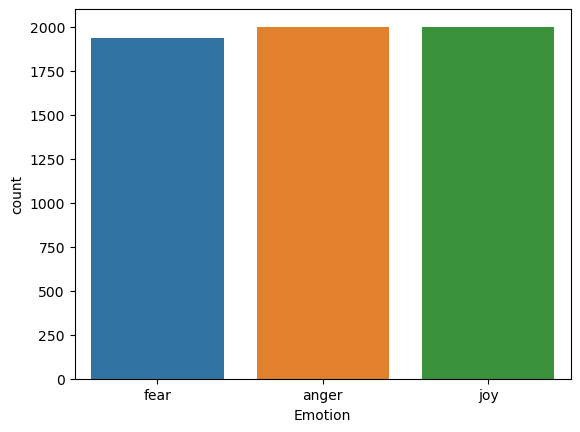

In [5]:
sns.countplot(df, x="Emotion")

In [6]:
for i in range(5):
  print(df["Comment"][i])

i seriously hate one subject to death but now i feel reluctant to drop it
im so full of life i feel appalled
i sit here to write i start to dig out my feelings and i think that i am afraid to accept the possibility that he might not make it
ive been really angry with r and i feel like an idiot for trusting him in the first place
i feel suspicious if there is no one outside like the rapture has happened or something


In [7]:
pd.get_dummies(df['Emotion'], dtype='int')

,anger,fear,joy
0,0,1,0
1,1,0,0
2,0,1,0
3,0,0,1
4,0,1,0
...,...,...,...
5932,0,1,0
5933,1,0,0
5934,0,0,1
5935,0,1,0


In [8]:
df.head()

,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear


In [9]:
train_df, valid_df = train_test_split(df, test_size=0.15, stratify=df['Emotion'], random_state=42)

In [10]:
train_df

,Comment,Emotion
917,i didnt want aubrey to feel pressured or rushe...,fear
4558,i was feeling grouchy and upset about a situat...,anger
598,im feelin spiteful so well actually visit my h...,anger
5586,i don t want to tell people how my first was w...,joy
910,i signed the petition and knowing that it will...,fear
...,...,...
101,i feel envious that they can keep their posts ...,anger
1983,i notice that i feel a little apprehensive eve...,fear
5501,i feel that im not talented in baking,joy
4903,i feel hesitant about talking about this,fear


In [11]:
y_train_one_hot = pd.get_dummies(train_df['Emotion'], dtype="int").values
y_val_one_hot = pd.get_dummies(valid_df['Emotion'], dtype="int").values

In [12]:
y_train_one_hot

array([[0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0]])

In [13]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['Comment'].values, y_train_one_hot))
  train_data = train_data.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

  val_data = tf.data.Dataset.from_tensor_slices((valid_df['Comment'].values, y_val_one_hot))
  val_data = val_data.cache().batch(32).prefetch(tf.data.AUTOTUNE)

  for text, label in train_data.take(1):
    for i in range(5):
     print(text[i].numpy(), label[i].numpy())
     print()

b'i am feeling inspired to write a parody piece but not today as i have been in too much of a bad mood' [0 0 1]

b'i still have such a hard time writing my work down and when i do i feel its not perfect' [0 0 1]

b'i feel like she has taken on the role of a grandmother to me since my beloved grandma is no longer with me' [0 0 1]

b'i can t help but feel petrified of the future is she ever going to get better' [0 1 0]

b'i apologise in advance i m feeling somewhat angered and stressed and the following is just going to have to come out' [1 0 0]



2023-12-06 18:17:23.514370: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-12-06 18:17:23.596229: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [14]:
def build_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
  preprocessor = hub.KerasLayer(
      "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
  encoder_inputs = preprocessor(text_input)
  encoder = hub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-12-h-768-a-12/versions/2",
    trainable=True)
  outputs_enc = encoder(encoder_inputs)
  pooled_output = outputs_enc["pooled_output"]
  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  dense = tf.keras.layers.Dense(128, activation="relu")(drop)
  outputs = tf.keras.layers.Dense(3, activation="softmax")(dense)
  return tf.keras.Model(text_input, outputs)

In [15]:
model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

KeyboardInterrupt: 

In [ ]:
model.summary()

In [19]:
epochs = 5
history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=epochs,
                    verbose=1)

Epoch 1/5
158/158 [==============================] - 188s 906ms/step - loss: 0.4800 - accuracy: 0.7895 - val_loss: 0.1343 - val_accuracy: 0.9585
Epoch 2/5
158/158 [==============================] - 144s 911ms/step - loss: 0.0930 - accuracy: 0.9637 - val_loss: 0.1234 - val_accuracy: 0.9607
Epoch 3/5
158/158 [==============================] - 145s 918ms/step - loss: 0.0486 - accuracy: 0.9812 - val_loss: 0.1298 - val_accuracy: 0.9540
Epoch 4/5
158/158 [==============================] - 144s 910ms/step - loss: 0.0432 - accuracy: 0.9832 - val_loss: 0.1471 - val_accuracy: 0.9641
Epoch 5/5
158/158 [==============================] - 143s 908ms/step - loss: 0.0239 - accuracy: 0.9899 - val_loss: 0.1533 - val_accuracy: 0.9596


In [20]:
history.history

{'loss': [0.4800202250480652,
  0.09301834553480148,
  0.048577696084976196,
  0.04322383180260658,
  0.023857565596699715],
 'accuracy': [0.7895362377166748,
  0.9637336730957031,
  0.9811732172966003,
  0.9831549525260925,
  0.9898929595947266],
 'val_loss': [0.1343449056148529,
  0.12344985455274582,
  0.12977808713912964,
  0.14710496366024017,
  0.1533203125],
 'val_accuracy': [0.9584736227989197,
  0.9607182741165161,
  0.953984260559082,
  0.9640852808952332,
  0.9595959782600403]}

In [21]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [22]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

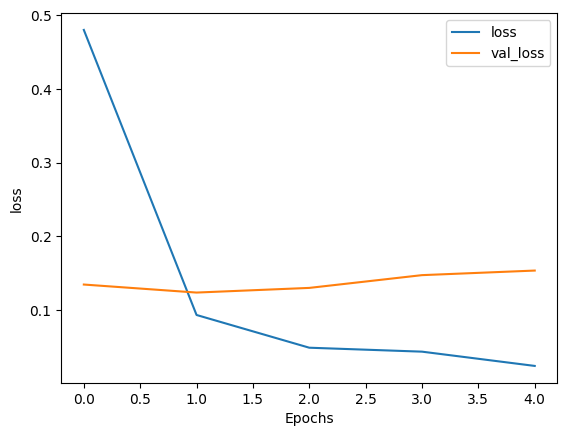

In [23]:
plot_graphs(history=history, metric='loss')

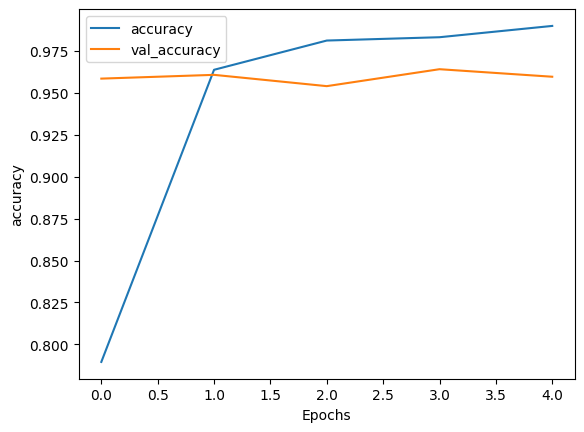

In [24]:
plot_graphs(history=history, metric='accuracy')

In [25]:
sample_example = ["I am very sick"]
pred = model.predict(sample_example)

1/1 [==============================] - 1s 796ms/step


In [26]:
predicted_class_index = np.argmax(pred)

In [27]:
classes = ['anger', 'joy', 'fear']

predicted_class_label = classes[predicted_class_index]

print("Predicted Class Index:", predicted_class_index)
print("Predicted Class Label:", predicted_class_label)

Predicted Class Index: 1
Predicted Class Label: joy


In [28]:
!pip install gradio jinja2

  Obtaining dependency information for gradio from https://files.pythonhosted.org/packages/67/bb/4a01345de5f30b897d8463921bf341a6dffcb5d73656a660e9e9160e2196/gradio-4.8.0-py3-none-any.whl.metadata
  Obtaining dependency information for aiofiles<24.0,>=22.0 from https://files.pythonhosted.org/packages/c5/19/5af6804c4cc0fed83f47bff6e413a98a36618e7d40185cd36e69737f3b0e/aiofiles-23.2.1-py3-none-any.whl.metadata
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for gradio-client==0.7.1 from https://files.pythonhosted.org/packages/2e/9e/ce7b34549e418cb7a1c1b541cf5f108f32be08e9ef31eb061fc5218c0091/gradio_client-0.7.1-py3-none-any.whl.metadata
  Obtaining dependency information for httpx from https://files.pythonhosted.org/packages/a2/65/6940eeb21dcb2953778a6895281c179efd9100463ff08cb6232bb6480da7/httpx-0.25.2-py3-none-any.whl.metadata
  Obtaining dependency information for pydantic>=2.0 from https://files.pythonhosted.org/packages/0a/2b/64066de1c4cf3d4ed623beeb3bbf3f

In [31]:
model_save_path = "version/v1"
model.save(model_save_path)

In [17]:
model = tf.keras.models.load_model("./model")

2023-12-06 23:00:17.563513: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.
2023-12-06 23:00:17.589159: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.
2023-12-06 23:00:17.589583: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.


In [18]:
model.predict(np.expand_dims('I am happy', 0))

1/1 [==============================] - 3s 3s/step


array([[5.8926395e-05, 2.0051775e-05, 9.9992096e-01]], dtype=float32)

In [19]:
def emotion_from_message(message):
    classes = ['anger',  'fear', 'joy']

    
    results = model.predict(np.expand_dims(message, 0))
    predicted_class_index = np.argmax(results)
    predicted_class_label = classes[predicted_class_index]

    print("Predicted Class Index:", predicted_class_index)
    print("Predicted Class Label:", predicted_class_label)
   
    return predicted_class_label

In [24]:
print(emotion_from_message("I heard strange noises outside my window late at night. My heart was racing, and I felt a sense of dread."))

1/1 [==============================] - 0s 371ms/step
Predicted Class Index: 1
Predicted Class Label: fear
fear


In [26]:
!pip install gradio

  Obtaining dependency information for gradio from https://files.pythonhosted.org/packages/67/bb/4a01345de5f30b897d8463921bf341a6dffcb5d73656a660e9e9160e2196/gradio-4.8.0-py3-none-any.whl.metadata
  Obtaining dependency information for altair<6.0,>=4.2.0 from https://files.pythonhosted.org/packages/c5/e4/7fcceef127badbb0d644d730d992410e4f3799b295c9964a172f92a469c7/altair-5.2.0-py3-none-any.whl.metadata
  Using cached ffmpy-0.3.1-py3-none-any.whl
  Obtaining dependency information for gradio-client==0.7.1 from https://files.pythonhosted.org/packages/2e/9e/ce7b34549e418cb7a1c1b541cf5f108f32be08e9ef31eb061fc5218c0091/gradio_client-0.7.1-py3-none-any.whl.metadata
  Obtaining dependency information for orjson~=3.0 from https://files.pythonhosted.org/packages/5a/23/42d1db93fd31ee9fea79c448ddb511fa574f6f281d3bdfa9e2c7d943296a/orjson-3.9.10-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 157.5 kB/s eta 0:00:00 kB/s e

In [27]:
import gradio as gr

In [34]:
interface = gr.Interface(fn=emotion_from_message, 
                         inputs=gr.Textbox(lines=2, placeholder='Write your message here'),
                        outputs='text')

In [35]:
interface.launch(show_api=False)  

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 1s 709ms/step
Predicted Class Index: 0
Predicted Class Label: anger
1/1 [==============================] - 1s 642ms/step
Predicted Class Index: 0
Predicted Class Label: anger
1/1 [==============================] - 1s 518ms/step
Predicted Class Index: 2
Predicted Class Label: joy
1/1 [==============================] - 1s 656ms/step
Predicted Class Index: 1
Predicted Class Label: fear
1/1 [==============================] - 1s 578ms/step
Predicted Class Index: 0
Predicted Class Label: anger
1/1 [==============================] - 1s 635ms/step
Predicted Class Index: 0
Predicted Class Label: anger
1/1 [==============================] - 1s 604ms/step
Predicted Class Index: 1
Predicted Class Label: fear
1/1 [==============================] - 0s 489ms/step
Predicted Class Index: 1
Predicted Class Label: fear
1/1 [==============================] - 1s 837ms/step
Predicted Class Index: 2
Predicted Class Label: joy
1/1 [==============================] - 0s 49